In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
# Download data
def get_portfolio_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    if isinstance(data, pd.Series):
        data = data.to_frame()
    return data

# Calculate returns
def calculate_returns(data):
    return data.pct_change().dropna()

# Historical simulation for VaR and CVaR
def historical_simulation_var_cvar(returns, weights, confidence_level):
    portfolio_returns = returns.dot(weights)
    sorted_returns = np.sort(portfolio_returns)
    var_index = int((1 - confidence_level) * len(sorted_returns))
    var = sorted_returns[var_index]
    cvar = sorted_returns[:var_index].mean()
    return var, cvar

In [4]:
# User input
print("Portfolio Configuration:")
num_assets = int(input("Enter the number of assets in the portfolio (min: 2, max: 10): "))

tickers = []
for i in range(num_assets):
    ticker = input(f"Enter ticker symbol for Asset {i+1} (e.g., AAPL, MSFT): ")
    tickers.append(ticker)

start_date = input("Enter start date for historical data (YYYY-MM-DD): ")
end_date = input("Enter end date for historical data (YYYY-MM-DD): ")

print("\nEnter portfolio weights for each asset (should sum to 1.0):")
weights = []
for ticker in tickers:
    weight = float(input(f"Weight for {ticker} (as a fraction, e.g., 0.25 for 25%): "))
    weights.append(weight)
weights = np.array(weights)

initial_investment = float(input("\nEnter initial investment amount ($): "))
confidence_level = float(input("Enter confidence level for VaR & CVaR (e.g., 0.95): "))

stressed_asset_index = int(input(f"Choose asset to stress (1-{num_assets}): ")) - 1
stress_shock = float(input(f"Enter shock for {tickers[stressed_asset_index]} (%) [-50 to 50]: "))


Portfolio Configuration:
Enter the number of assets in the portfolio (min: 2, max: 10): 3
Enter ticker symbol for Asset 1 (e.g., AAPL, MSFT): AAPL
Enter ticker symbol for Asset 2 (e.g., AAPL, MSFT): MSFT
Enter ticker symbol for Asset 3 (e.g., AAPL, MSFT): GOOG
Enter start date for historical data (YYYY-MM-DD): 2023-12-02
Enter end date for historical data (YYYY-MM-DD): 2024-11-02

Enter portfolio weights for each asset (should sum to 1.0):
Weight for AAPL (as a fraction, e.g., 0.25 for 25%): 0.25
Weight for MSFT (as a fraction, e.g., 0.25 for 25%): 0.25
Weight for GOOG (as a fraction, e.g., 0.25 for 25%): 0.5

Enter initial investment amount ($): 1000
Enter confidence level for VaR & CVaR (e.g., 0.95): 0.95
Choose asset to stress (1-3): 2
Enter shock for MSFT (%) [-50 to 50]: -10


In [5]:
# Load and process data
data = get_portfolio_data(tickers, start_date, end_date)
returns = calculate_returns(data)

# Apply stress testing
stressed_returns = returns.copy()
stressed_returns.iloc[:, stressed_asset_index] *= (1 + stress_shock / 100)

# Calculate VaR and CVaR
var_original, cvar_original = historical_simulation_var_cvar(returns, weights, confidence_level)
var_stressed, cvar_stressed = historical_simulation_var_cvar(stressed_returns, weights, confidence_level)

# Output results
print("\nRisk Metrics:")
print(f"Original Portfolio - VaR: ${var_original * initial_investment:.2f}, CVaR: ${cvar_original * initial_investment:.2f}")
print(f"Stressed Portfolio - VaR: ${var_stressed * initial_investment:.2f}, CVaR: ${cvar_stressed * initial_investment:.2f}")



[*********************100%***********************]  3 of 3 completed


Risk Metrics:
Original Portfolio - VaR: $-19.75, CVaR: $-28.65
Stressed Portfolio - VaR: $-19.12, CVaR: $-27.83


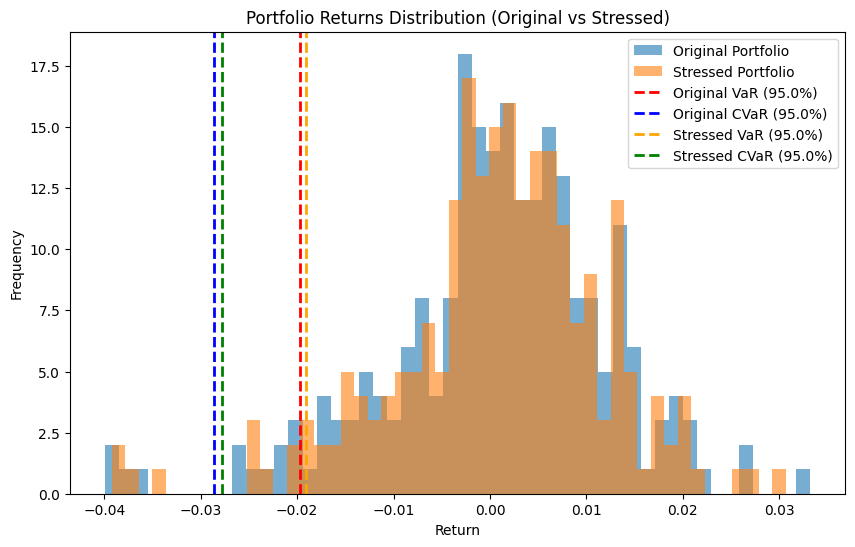

In [6]:
# Visualization
portfolio_returns = returns.dot(weights)
stressed_portfolio_returns = stressed_returns.dot(weights)

plt.figure(figsize=(10, 6))
plt.hist(portfolio_returns, bins=50, alpha=0.6, label='Original Portfolio')
plt.hist(stressed_portfolio_returns, bins=50, alpha=0.6, label='Stressed Portfolio')
plt.axvline(var_original, color='red', linestyle='dashed', linewidth=2, label=f'Original VaR ({confidence_level * 100}%)')
plt.axvline(cvar_original, color='blue', linestyle='dashed', linewidth=2, label=f'Original CVaR ({confidence_level * 100}%)')
plt.axvline(var_stressed, color='orange', linestyle='dashed', linewidth=2, label=f'Stressed VaR ({confidence_level * 100}%)')
plt.axvline(cvar_stressed, color='green', linestyle='dashed', linewidth=2, label=f'Stressed CVaR ({confidence_level * 100}%)')
plt.legend()
plt.title('Portfolio Returns Distribution (Original vs Stressed)')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()
